In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

### 讀檔
* 將年月日組合
* 取每日pm2.5的平均
* 選取最後30天為test data

In [2]:
data = pd.read_csv('data/PRSA_data_2010.1.1-2014.12.31.csv',
                   parse_dates=[['year','month','day']])

In [3]:
data = pd.DataFrame(data.groupby(['year_month_day'])['pm2.5'].mean())
data.index = pd.date_range(start='2010-01-01', end='2014-12-31', freq='D')
data = data.fillna(0)
data.head()

,pm2.5
2010-01-01,0.000000
2010-01-02,145.958333
2010-01-03,78.833333
2010-01-04,31.333333
2010-01-05,42.458333


In [4]:
train = data.iloc[:-30]
test = data.iloc[-30:]

### 畫圖
* 檢查資料平穩性
* 畫ACF和 PACF
* AIC和 BIC選模型參數

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import itertools

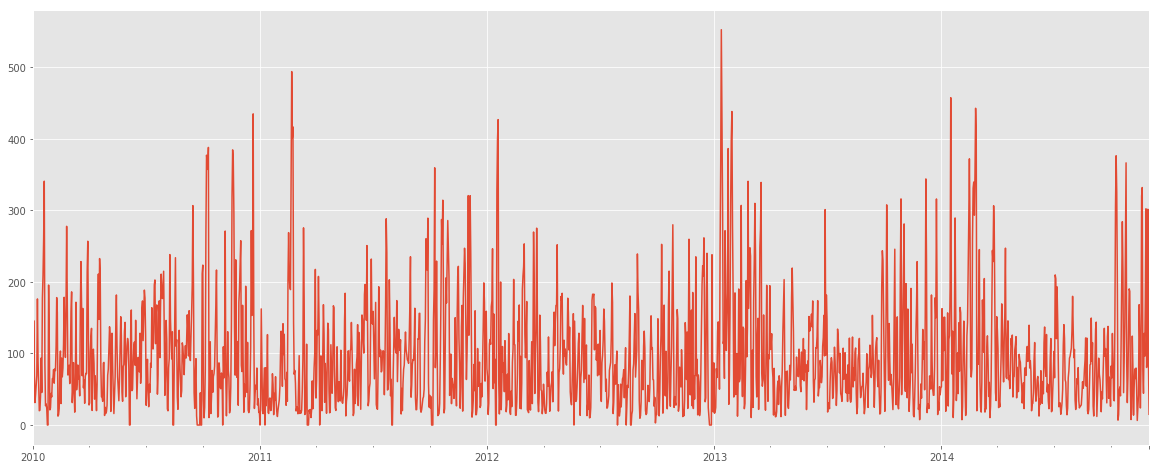

In [6]:
train['pm2.5'].plot(figsize=(20,8))
plt.show()

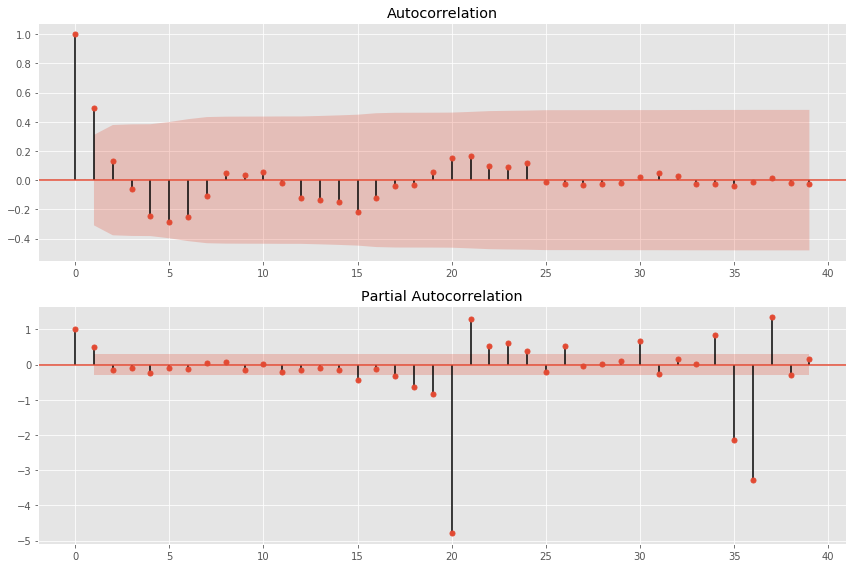

In [7]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211) # 2X1網格,第1子圖
fig = sm.graphics.tsa.plot_acf(train['pm2.5'].values[:40], ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train['pm2.5'].values[:40], ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()

In [8]:
p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min, p_max + 1)],
                           columns=['MA{}'.format(i) for i in range(q_min, q_max + 1)])

for p, d, q in itertools.product(range(p_min,p_max + 1),
                                 range(d_min,d_max + 1),
                                 range(q_min,q_max + 1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = sm.tsa.SARIMAX(train, order=(p, d, q))
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

C:\Users\Jason\Anaconda3\envs\tensorFlow\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Jason\Anaconda3\envs\tensorFlow\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Jason\Anaconda3\envs\tensorFlow\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [9]:
results_bic

,MA0,MA1,MA2,MA3,MA4
AR0,NaN,21185.981377,20823.467057,20639.015574,20581.615426
AR1,20366.904812,20373.803366,20131.758846,20082.881723,NaN
AR2,20374.084345,NaN,NaN,20078.615505,NaN
AR3,20314.704076,20071.166182,NaN,NaN,NaN
AR4,20293.613943,20078.448820,NaN,NaN,NaN


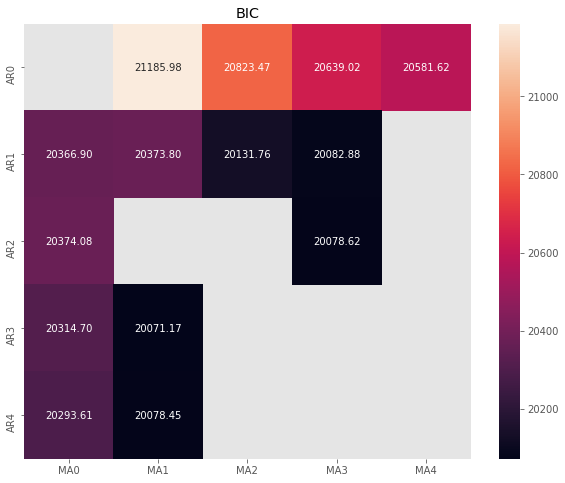

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

In [11]:
train_results = sm.tsa.arma_order_select_ic(train, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

C:\Users\Jason\Anaconda3\envs\tensorFlow\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Jason\Anaconda3\envs\tensorFlow\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Jason\Anaconda3\envs\tensorFlow\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Jason\Anaconda3\envs\tensorFlow\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Jason\Anaconda3\envs\tensorFlow\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inve

AIC (4, 2)
BIC (2, 2)


C:\Users\Jason\Anaconda3\envs\tensorFlow\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## 建立模型
* order 選(3,0,1)

In [12]:
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [13]:
arima200 = sm.tsa.SARIMAX(train['pm2.5'], order=(3,0,1))
model_results = arima200.fit()    

C:\Users\Jason\Anaconda3\envs\tensorFlow\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


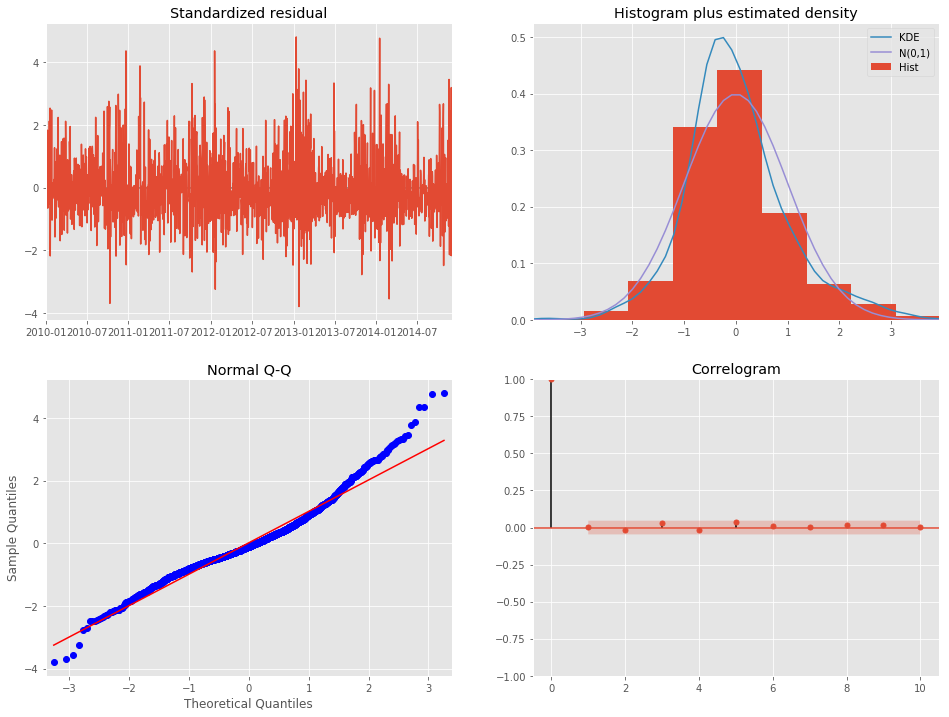

In [14]:
model_results.plot_diagnostics(figsize=(16, 12));

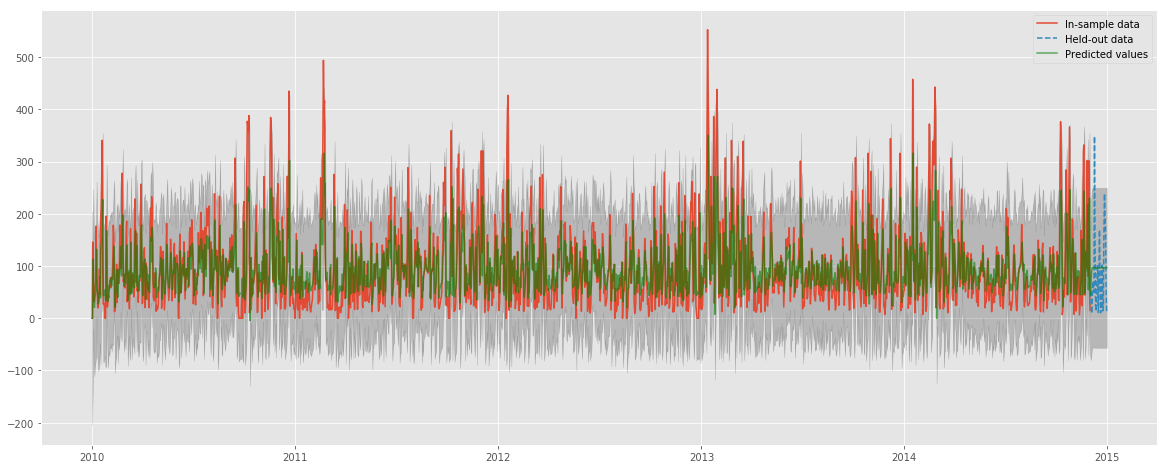

In [15]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
    
ax1.plot(train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = train.index[model_results.loglikelihood_burn]
pred_end = test.index[-1]
pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'g', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

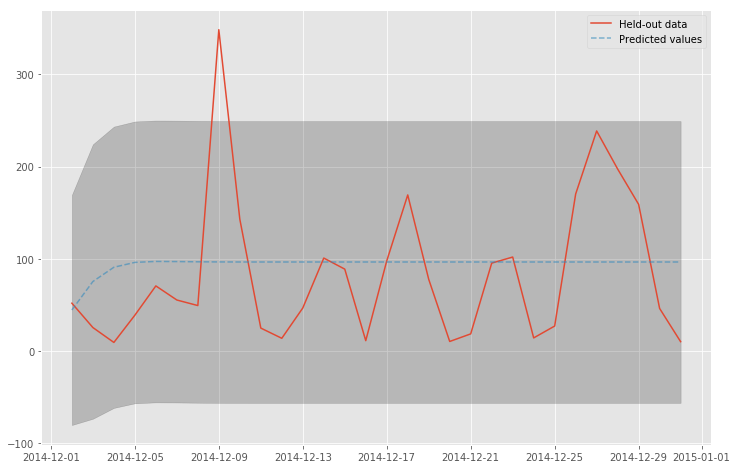

In [16]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(test, label='Held-out data', linestyle='-')
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean[-30:], alpha=.6, label='Predicted values', linestyle='--')
ax1.fill_between(pred_ci.iloc[-30:, 0].index,
                 pred_ci.iloc[-30:, 0],
                 pred_ci.iloc[-30:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

In [17]:
print('RMSE: {}'.format(sqrt(mean_squared_error(test['pm2.5'], pred_mean[-30:]))))

RMSE: 78.5806933690581


## ARMA Model

In [18]:
model = ARMA(train['pm2.5'], order=(4, 2))
result_arma = model.fit(disp=-1)
pred_begin = test.index[model_results.loglikelihood_burn]
pred_end = test.index[-1]
pred = result_arma.predict(start=pred_begin,
                           end=pred_end)

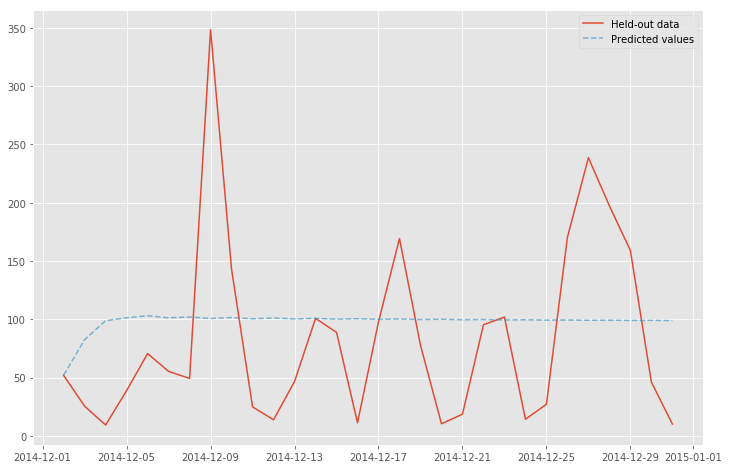

In [19]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
# ax1.plot(train['pm2.5'][-30:], label='Held-out data', linestyle='-')
ax1.plot(test, label='Held-out data', linestyle='-')
ax1.plot(pred, alpha=.6, label='Predicted values', linestyle='--')
ax1.legend(loc='best');

In [20]:
print('RMSE:{}'.format(sqrt(mean_squared_error(test['pm2.5'], pred[-30:]))))

RMSE:79.48295093289255
